In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nba_py import shotchart
from nba_py import player
from matplotlib import colors
import seaborn as sns
%matplotlib inline

In [2]:
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -48), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [8]:

def create_bins(df, bin_number_x = 30, bin_number_y=300 / (500.0 / 30.0), max_size_given = None, league_average = None,  \
                width = 500, height = 300, norm_x = 250, norm_y = 48):
    x_bins, y_bins = [], []
    copied_df = df.copy()
    keys = []
    location_counts, location_made = {}, {}
    locations_shots = {} # real locations of shots which will be connected to bins and later arithmetic middle will
                         # be found
    bin_size_x = width / float(bin_number_x)
    bin_size_y = height / float(bin_number_y)
    locations_annotated = []
    zones_counts, zones_made = {}, {}
    
    if bin_number_x < 20:
        multiplier = 1
    elif bin_number_x <= 25:
        multiplier = 1.5
    elif bin_number_x <= 30:
        multiplier = 2
    elif bin_number_x <= 45:
        multiplier = 3
    else:
        multiplier = 4
    if max_size_given is None:
        max_size = float(multiplier * bin_size_x * bin_size_y)
    else:
        max_size = float(max_size_given)
        
    restricted_area_keys = []
    
    for i in range(len(df)):
        x_shot_orig, y_shot_orig = df.iloc[i].LOC_X, df.iloc[i].LOC_Y
        x_shot = x_shot_orig + norm_x # to put minimum to zero
        y_shot = y_shot_orig + norm_y # to put minimum to zero (.5 is lacking, but just so i can be working with integers)
        
        # bin_index = (x_shot / w) * bin_size
        curr_x_bin = 0 if x_shot == 0 else int((x_shot / float(width)) * bin_number_x)    
        curr_y_bin = 0 if y_shot == 0 else int((y_shot / float(height)) * bin_number_y)
        
        #x_bins.append(curr_bin_x_coord)
        #y_bins.append(curr_bin_y_coord)
        
        key = (curr_x_bin, curr_y_bin)
        
        if df.iloc[i].SHOT_ZONE_BASIC == "Restricted Area":
            restricted_area_keys.append(key)
        
        keys.append(key)
        if key in location_counts:
            location_counts[key] = location_counts[key] + 1
        else:
            location_counts[key] = 1
        
        if key in location_made:
            location_made[key] = location_made[key] + df.iloc[i].SHOT_MADE_FLAG
        else:
            location_made[key] = df.iloc[i].SHOT_MADE_FLAG
            
        if key in locations_shots:
            locations_shots[key].append((x_shot_orig, y_shot_orig))
        else:
            locations_shots[key] = [(x_shot_orig, y_shot_orig)]
            
        basic_shot_zone, shot_zone_area = df.iloc[i].SHOT_ZONE_BASIC, df.iloc[i].SHOT_ZONE_AREA
        zone_dist = df.iloc[i].SHOT_ZONE_RANGE
        area_code = shot_zone_area.split("(")[1].split(")")[0]
        if "3" in basic_shot_zone:
            locations_annotated.append("3" + area_code)
        elif "Paint" in basic_shot_zone:
            locations_annotated.append("P" + area_code + zone_dist[0])
        elif "Mid" in basic_shot_zone:
            locations_annotated.append("M" + area_code + zone_dist[0])
        else:
            locations_annotated.append("R" + area_code)
        
        zone_key = (basic_shot_zone, shot_zone_area, zone_dist)
        if zone_key not in zones_counts:
            zones_counts[zone_key] = 1
        else:
            zones_counts[zone_key] = zones_counts[zone_key] + 1
        
        if df.iloc[i].SHOT_MADE_FLAG:
            if zone_key not in zones_made:
                zones_made[zone_key] = 1
            else:
                zones_made[zone_key] = zones_made[zone_key] + 1
        
    shot_locations_percentage = [] # percentage in given bin
    shot_locations_counts = []
    raw_counts = []
    key_x, key_y = [], []
    league_avg_comp = []
    plot_x, plot_y = [], []
    per_zone_percentage = []
    
    max_shots_at_location = float(max(location_counts.values()))
    # max_per_locations = 10.0
    max_out_of_restricted, second_biggest = None, None
    restricted_area, non_ra = [], []
    for key in location_counts:
        if key not in restricted_area_keys:
            if location_counts[key] not in non_ra:
                non_ra.append(location_counts[key])
        else:
            restricted_area.append((location_counts[key], key))
    
    sorted_non_ra = sorted(non_ra)
    max_out_of_restricted, second_biggest = float(sorted_non_ra[-1]), float(sorted_non_ra[-2])
    restricted_area_sorted = restricted_area.sort(key=lambda x : x[0])
    found_pairs = []
    binned_found = []
    
    for j in range(len(df)):
        key = keys[j]
        shot_percent = float(location_made[key]) / location_counts[key]
        # shot_percent = np.clip(shot_percent, 0.3, 0.7)
        shot_locations_percentage.append(shot_percent * 100)
        is_restricted = df.iloc[j].SHOT_ZONE_BASIC == "Restricted Area"
        if league_average is not None:
            shot_zone_basic, shot_zone_area = df.iloc[j].SHOT_ZONE_BASIC, df.iloc[j].SHOT_ZONE_AREA
            distance = df.iloc[j].SHOT_ZONE_RANGE
            zone_key = (shot_zone_basic, shot_zone_area, distance)
            if zone_key not in zones_made:
                zone_percent = 0.0
            else:
                zone_percent = float(zones_made[zone_key]) / float(zones_counts[zone_key])
            avg_percentage = league_average.loc[(league_average.SHOT_ZONE_BASIC == shot_zone_basic) & \
                                                (league_average.SHOT_ZONE_AREA == shot_zone_area) & \
                                               (league_average.SHOT_ZONE_RANGE == distance)].FG_PCT.iloc[0]
            league_avg_comp.append(np.clip((shot_percent - avg_percentage) * 100, -20, 20))
            if is_restricted:
                per_zone_percentage.append(np.clip((shot_percent - avg_percentage) * 100, -20, 20))
            else:
                per_zone_percentage.append(np.clip((zone_percent - avg_percentage) * 100, -20, 20))
        
        if is_restricted:
            # Debug it
            value_to_scale = max_out_of_restricted
            curr_value = location_counts[key]
            if location_counts[key] < max_out_of_restricted:
                value_to_scale = second_biggest
            shot_locations_counts.append( float(value_to_scale) / max_out_of_restricted * max_size )
        else:
            value_to_scale = location_counts[key]
            if value_to_scale >= second_biggest:
                value_to_scale = second_biggest
            shot_locations_counts.append( float(value_to_scale) / second_biggest * max_size )
        
        # shot_locations_counts.append( location_counts[key] / max_shots_at_location * max_size )
        raw_counts.append(location_counts[key])
        
        all_x_locs = [x_loc for x_loc, y_loc in locations_shots[key]]
        all_y_locs = [y_loc for x_loc, y_loc in locations_shots[key]]
        
        # binned_x, binned_y = np.mean(all_x_locs), np.mean(all_y_locs)

        x_bin, y_bin = key[0], key[1]
        binned_x = ((x_bin * float(width)) / bin_number_x + ((x_bin+1) * float(width)) / bin_number_x) / 2 - norm_x
        binned_y = ((y_bin * float(height)) / bin_number_y + ((y_bin+1) * float(height)) / bin_number_y) / 2 - norm_y
        
        if (binned_x, binned_y) not in binned_found:
            x_bins.append(binned_x)
            y_bins.append(binned_y)
            binned_found.append((binned_x, binned_y))
        else:
            x_bins.append(0)
            y_bins.append(-100)
        
        if location_counts[key] > 1:
            if (binned_x, binned_y) not in found_pairs:
                plot_x.append(binned_x)
                plot_y.append(binned_y)
                found_pairs.append((binned_x, binned_y))
            else:
                plot_x.append(0)
                plot_y.append(-100)
        else:
            plot_x.append(df.iloc[j].LOC_X)
            plot_y.append(df.iloc[j].LOC_Y)
            
        
        key_x.append(key[0])
        key_y.append(key[1])
        
    copied_df['BIN_LOC_X'] = x_bins
    copied_df['BIN_LOC_Y'] = y_bins
    if league_average is not None:
        copied_df['PCT_LEAGUE_AVG_COMPARISON'] = league_avg_comp
        copied_df['PCT_LEAGUE_COMPARISON_ZONE'] = per_zone_percentage
    copied_df['LOC_PERCENTAGE'] = shot_locations_percentage
    copied_df['LOC_COUNTS'] = shot_locations_counts
    copied_df['LOC_RAW_COUNTS'] = raw_counts
    copied_df['BIN_X'] = key_x
    copied_df['BIN_Y'] = key_y
    copied_df['PLOT_X'] = plot_x
    copied_df['PLOT_Y'] = plot_y
    copied_df['LOCATION_CODE'] = locations_annotated
    
    return copied_df
    

In [4]:
plt.style.use('fivethirtyeight')

In [5]:
# setting up data
season = "2017-18"
player_name = "Stephen"
player_surname = "Curry"
player_id = player.get_player(player_name, player_surname, season=season)
player_data = shotchart.ShotChart(player_id=player_id, season=season)
league_average = player_data.league_average()

In [6]:
player_df = player_data.shot_chart()
player_df.LOC_X = -player_df.LOC_X # REAL DATA IS FLIPPED
player_df = player_df.loc[(player_df.SHOT_ZONE_AREA != "Back Court(BC)") & (player_df.LOC_Y < 300)] # drop shots that aren't close to the center
len(player_df)

269

In [8]:
league_average

,GRID_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,FGA,FGM,FG_PCT
0,League Averages,Above the Break 3,Back Court(BC),Back Court Shot,8,0,0.000
1,League Averages,Above the Break 3,Center(C),24+ ft.,2118,753,0.356
2,League Averages,Above the Break 3,Left Side Center(LC),24+ ft.,2748,979,0.356
3,League Averages,Above the Break 3,Right Side Center(RC),24+ ft.,2661,951,0.357
4,League Averages,Backcourt,Back Court(BC),Back Court Shot,81,1,0.012
5,League Averages,In The Paint (Non-RA),Center(C),8-16 ft.,1601,637,0.398
6,League Averages,In The Paint (Non-RA),Center(C),Less Than 8 ft.,2323,880,0.379
7,League Averages,In The Paint (Non-RA),Left Side(L),8-16 ft.,270,108,0.400
8,League Averages,In The Paint (Non-RA),Right Side(R),8-16 ft.,255,102,0.400
9,League Averages,Left Corner 3,Left Side(L),24+ ft.,1088,385,0.354


In [5]:
def get_shotchart_for_players(players, season="2017-18"):
    final_data = None
    for curr_player in players:
        name, surname = curr_player[0], curr_player[1]
        print name, surname
        curr_id = player.get_player(name, surname, season=season)
        player_data = shotchart.ShotChart(player_id=curr_id, season=season)
        player_data = player_data.shot_chart()
        player_data.LOC_X = -player_data.LOC_X # REAL DATA IS FLIPPED
        player_data = player_data.loc[(player_data.SHOT_ZONE_AREA != "Back Court(BC)") & (player_data.LOC_Y < 300)]
        if final_data is None:
            final_data = player_data
        else:
            final_data = final_data.append(player_data)
    return final_data

In [10]:
gsw_players = [["Klay","Thompson"], ["Stephen", "Curry"], ["Kevin", "Durant"]]
rockets_players = [["James", "Harden"], ["Eric", "Gordon"], ["Ryan", "Anderson"]]

league_average = shotchart.ShotChart(player_id=player.get_player("Kevin", "Durant", season=season)).league_average()
gsw_data, rockets_data = get_shotchart_for_players(gsw_players), get_shotchart_for_players(rockets_players)

Klay Thompson
Stephen Curry
Kevin Durant
James Harden
Eric Gordon
Ryan Anderson


In [11]:
print len(gsw_data)
print len(rockets_data)

573
542


In [10]:
season = "2017-18"
player_name = "Bojan"
player_surname = "Bogdanovic"
player_id = player.get_player(player_name, player_surname, season=season)
player_data = shotchart.ShotChart(player_id=player_id, season=season)
league_average = player_data.league_average()

player_df = player_data.shot_chart()
player_df.LOC_X = -player_df.LOC_X # REAL DATA IS FLIPPED
player_df = player_df.loc[(player_df.SHOT_ZONE_AREA != "Back Court(BC)") & (player_df.LOC_Y < 300)] # drop shots that aren't close to the center

In [9]:
print len(player_df)

172


In [6]:
boston_players = [["Kyrie", "Irving"], ["Al", "Horford"], ["Jaylen", "Brown"]]
season = "2017-18"

league_average = shotchart.ShotChart(player_id=player.get_player("Kyrie", "Irving", season=season)).league_average()
boston_data = get_shotchart_for_players(boston_players)

Kyrie Irving
Al Horford
Jaylen Brown


In [11]:
binned_df = create_bins(player_df, league_average=league_average)

In [12]:
cleared_df = binned_df
#cleared_df = binned_df.loc[binned_df.LOC_RAW_COUNTS>1]

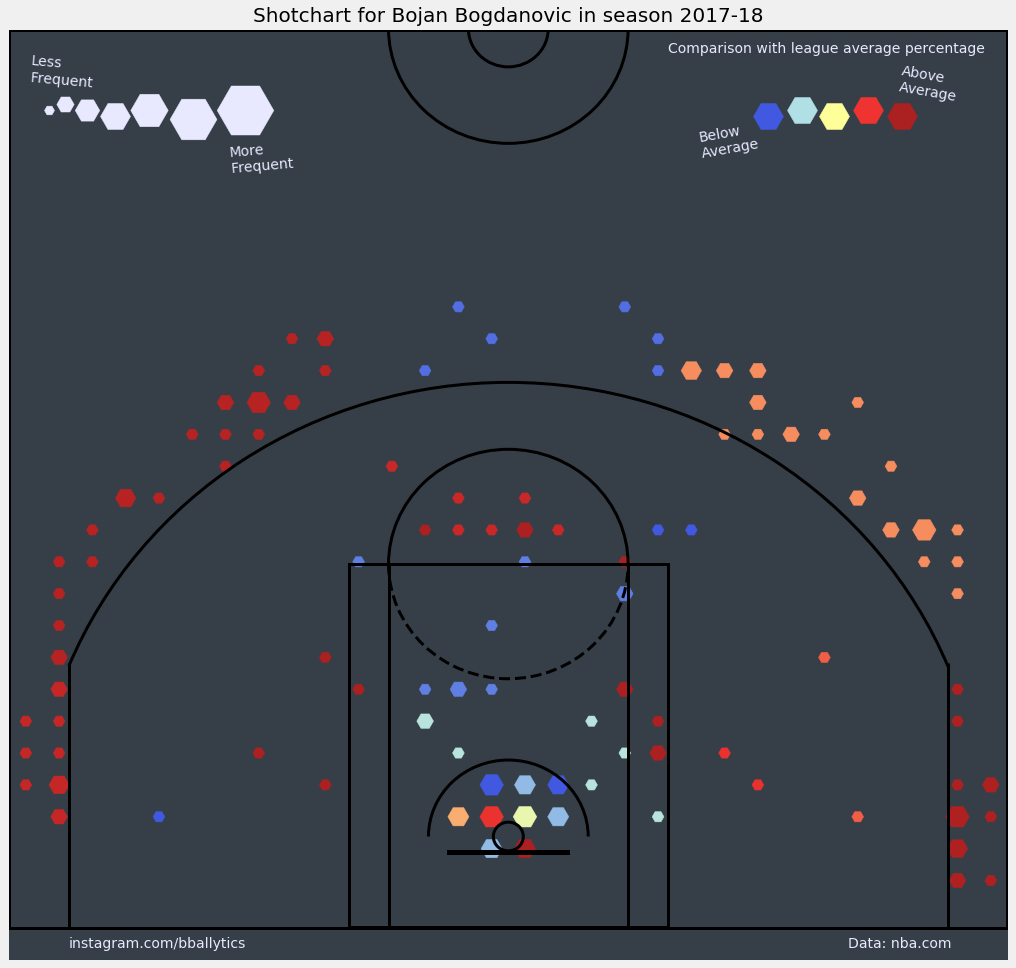

In [15]:
fig = plt.figure(figsize=(16, 16))
# colors_dict = {0:'red', 1:'green'}
cmap = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"], as_cmap=True)

# LOC_PERCENTAGE -> total perc
# PCT_LEAGUE_AVG_COMPARISON -> comparison per bins
# PCT_LEAGUE_COMPARISON_ZONE -> comparison per zones only
# LOC_X, LOC_Y -> real locs
# BIN_LOC_X, BIN_LOC_Y -> binned locations
marker = 'H'
paths = plt.scatter(x=cleared_df.BIN_LOC_X, y=cleared_df.BIN_LOC_Y, marker=marker, s=cleared_df.LOC_COUNTS, c=cleared_df.PCT_LEAGUE_COMPARISON_ZONE, cmap=cmap)

"""for i in range(len(cleared_df)):
    if cleared_df.iloc[i].LOCATION_CODE == "3C" or cleared_df.iloc[i].LOCATION_CODE == "RC":
        plt.text(x=cleared_df.iloc[i].LOC_X, y=cleared_df.iloc[i].LOC_Y, s=cleared_df.iloc[i].LOCATION_CODE, color="#E2E2FF")"""

# Frequency

plt.text(x=-240, y=395, s="Less\nFrequent", rotation=-5, color="#E8E8FF")
plt.scatter(x=-230, y=380, s=100, marker=marker, c="#E8E8FF")
plt.scatter(x=-222, y=383, s=300, marker=marker, c="#E8E8FF")
plt.scatter(x=-211, y=380, s=600, marker=marker, c="#E8E8FF")
plt.scatter(x=-197, y=377, s=900, marker=marker, c="#E8E8FF")
plt.scatter(x=-180, y=380, s=1400, marker=marker, c="#E8E8FF")
plt.scatter(x=-158, y=375, s=2200, marker=marker, c="#E8E8FF")
plt.scatter(x=-132, y=380, s=3200, marker=marker, c="#E8E8FF")
plt.text(x=-140, y=350, s="More\nFrequent", rotation=5, color="#E8E8FF")


# Efficiency

plt.text(x=80, y=410, s="Comparison with league average percentage", color="#E8E8FF")
plt.text(x=95, y=360, s="Below\nAverage", rotation=10, color="#E8E8FF")
plt.scatter(x=130, y=377, s=900, marker=marker, c="#4159E1")
plt.scatter(x=147, y=380, s=900, marker=marker, c="#B0E0E6")
plt.scatter(x=163, y=377, s=900, marker=marker, c="#FFFF99")
plt.scatter(x=180, y=380, s=900, marker=marker, c="#EF3330")
plt.scatter(x=197, y=377, s=900, marker=marker, c="#AB2020")
plt.text(x=195, y=390, s="Above\nAverage", rotation=-10, color="#E8E8FF")

# Changing court color
plt.gca().set_facecolor('#363F48')
curr_ax = plt.gca()

#plt.xticks(np.arange(-250, 251, 20))
#plt.yticks(np.arange(-50, 490, 20))
# Removing ticks
plt.xticks([])
plt.yticks([])

# Title
plt.title("Shotchart for Bojan Bogdanovic in season " + season, size=20)

# Drawing court
draw_court(outer_lines=True, lw=3)
plt.xlim(-251,251)
plt.ylim(-65,423)

plt.text(x=-220, y=-58, s="instagram.com/bballytics", color="#E8E8FF")
plt.text(x=170, y=-58, s="Data: nba.com", color="#E8E8FF")

# Colorbar
"""cax = fig.add_axes([0.7, 0.82, 0.2, 0.025])
colorbar = plt.colorbar(mappable=paths, cax=cax, orientation='horizontal', format='%d%%')
#colorbar = plt.colorbar(cax=cax, orientation='horizontal', format='%+d%%') # + is for positive percentage
cax.set_xlabel("Comparison to league average percentages",
            fontsize=12, labelpad=-60, color="#E2E2FF")
colorbar.outline.set_visible(False)
plt.setp(plt.getp(colorbar.ax.axes, 'xticklabels'), color="#E2E2FF", fontsize=10)
"""

# Saving figure
#plt.savefig('lebron.png', bbox_inches='tight')
#colorbar.set_label('Comparison to league average percentages', color='#E2E2FF', size=16, coords=(1.5, 1.5))
plt.show()

In [ ]:
binned_gsw = create_bins(gsw_data, league_average=league_average)
binned_hou = create_bins(rockets_data, league_average=league_average)

In [21]:
def prepare_data_frame(player_data, num_of_games):
    player_df = player_data.shot_chart()
    player_df.LOC_X = -player_df.LOC_X # REAL DATA IS FLIPPED
    player_df = player_df.loc[(player_df.SHOT_ZONE_AREA != "Back Court(BC)") & (player_df.LOC_Y < 300)] # drop shots that aren't close to the center
    grouped = list(player_df.groupby('GAME_ID'))
    adjusted_df = grouped[0][1]
    for g in grouped[1:num_of_games]:
        adjusted_df = adjusted_df.append(g[1])
    return adjusted_df

In [22]:
player_name = "Kyrie"
player_surname = "Irving"
player_id = player.get_player(player_name, player_surname)
player_data_past_season = shotchart.ShotChart(player_id=player_id, season='2016-17')
league_average_past = player_data_past_season.league_average()
player_data_curr_season = shotchart.ShotChart(player_id=player_id, season='2017-18')
league_average_curr = player_data_curr_season.league_average()

adjusted_past, adjusted_curr = prepare_data_frame(player_data_past_season, 16), prepare_data_frame(player_data_curr_season, 16)
binned_df_past = create_bins(adjusted_past, league_average=league_average_past)
binned_df_curr = create_bins(adjusted_curr, league_average=league_average_past)

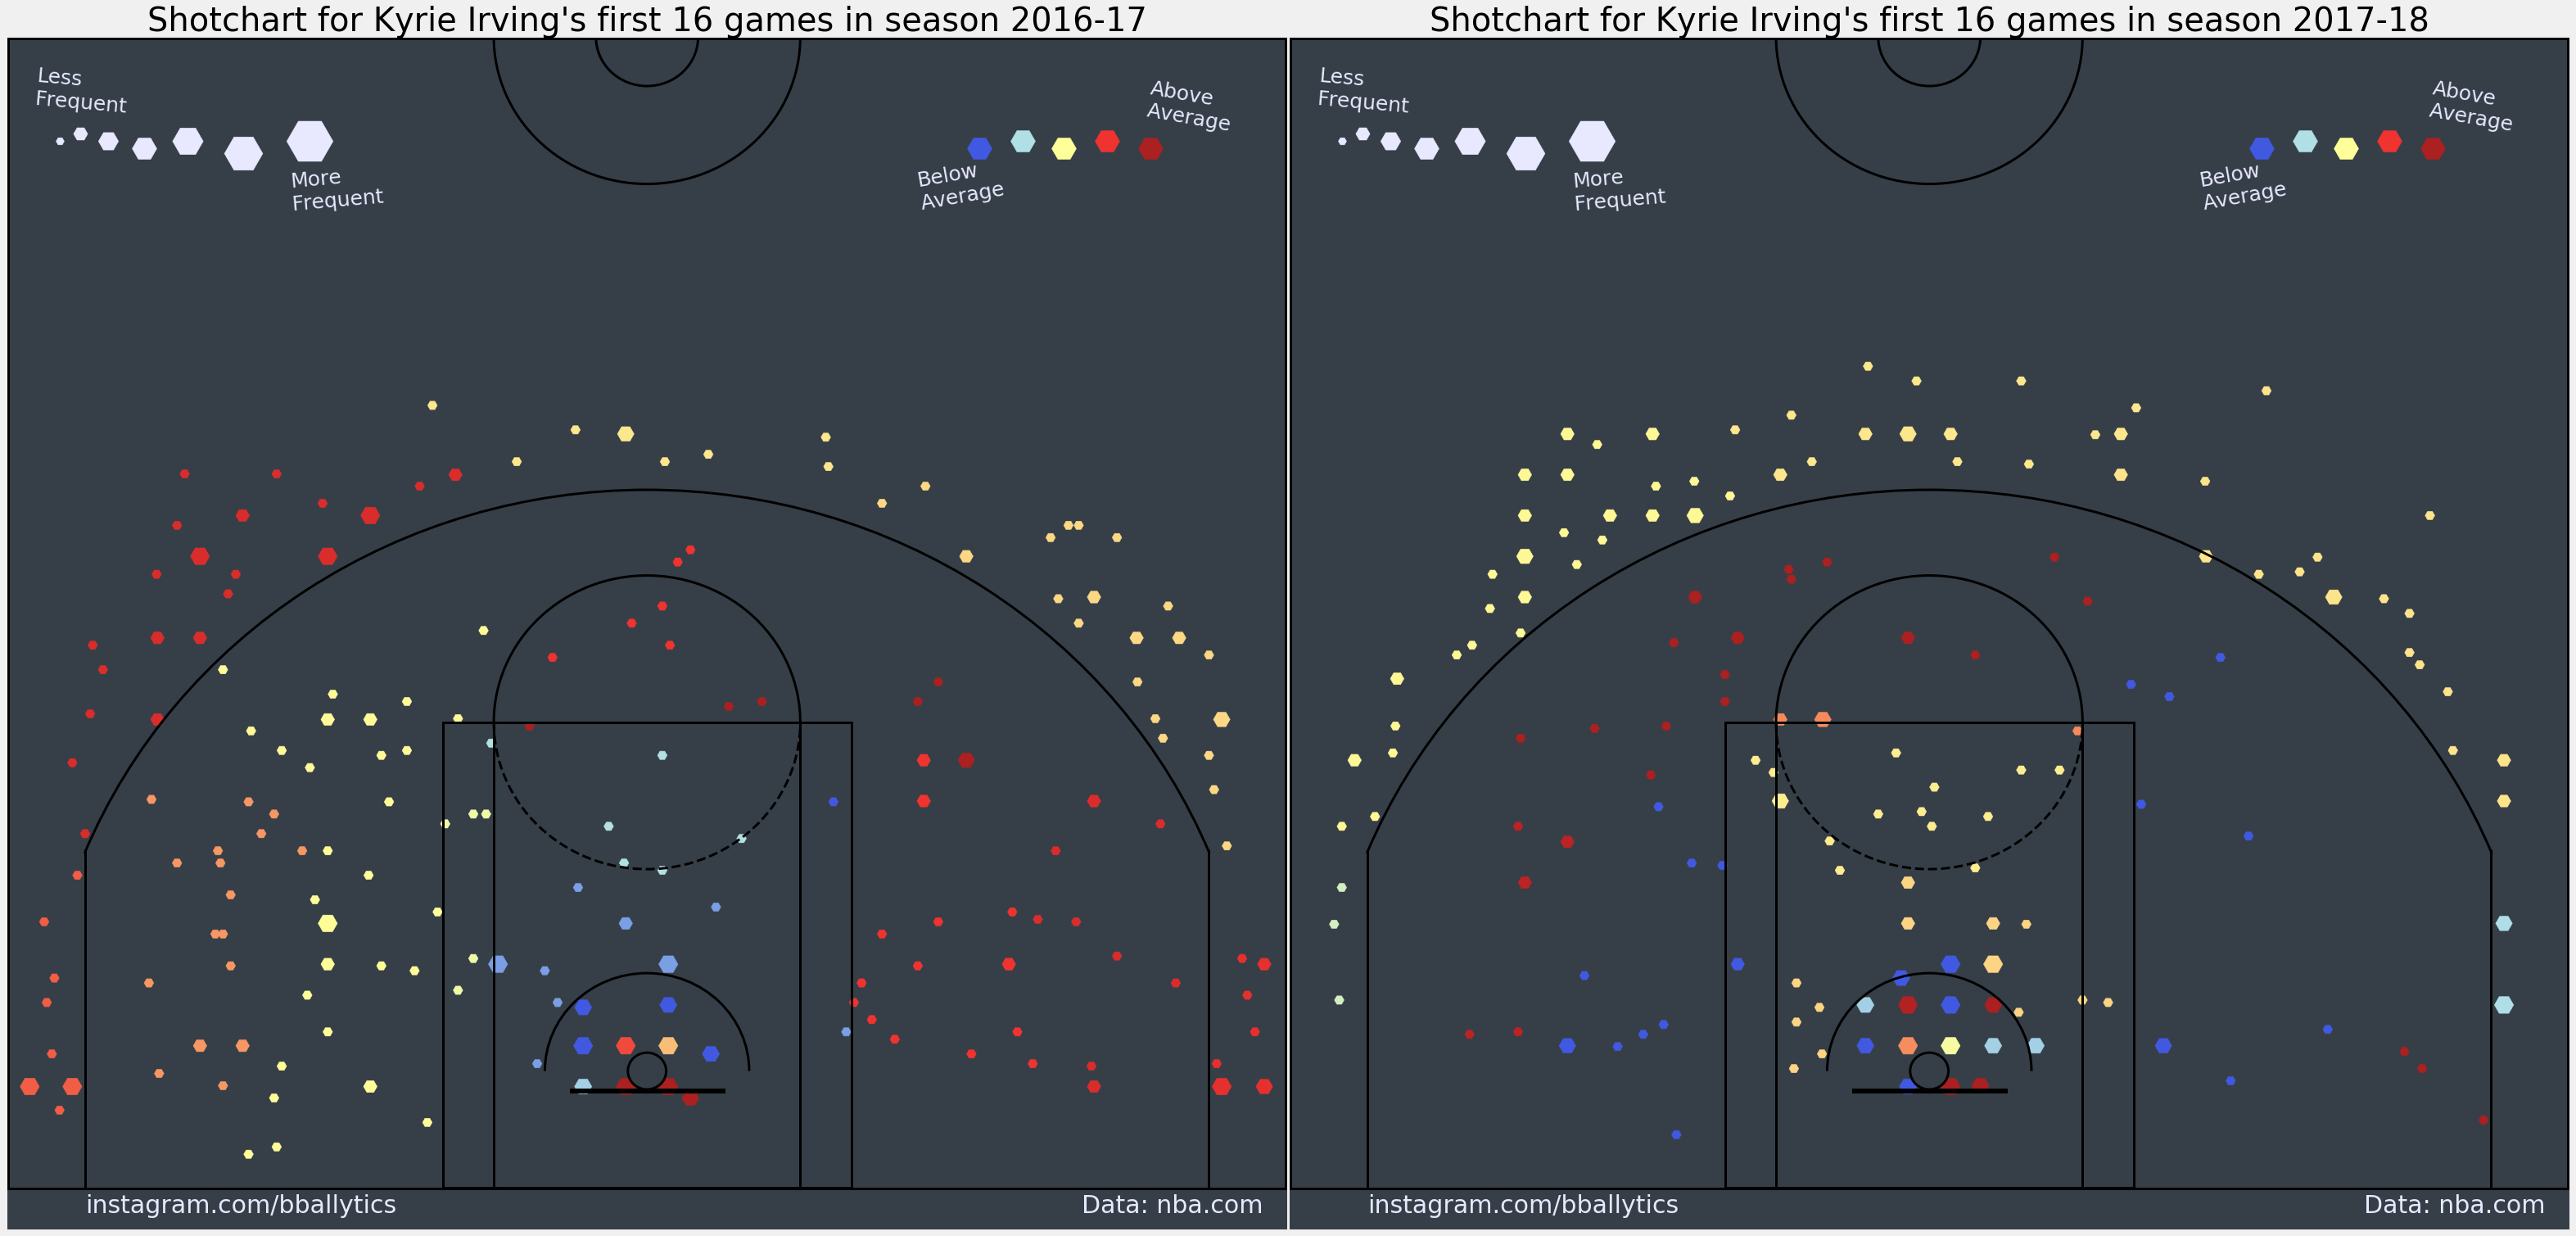

In [23]:
fig = plt.figure(figsize=(50, 25))
# colors_dict = {0:'red', 1:'green'}

plt.subplot(121)

cmap = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"], as_cmap=True)

# LOC_PERCENTAGE -> total perc
# PCT_LEAGUE_AVG_COMPARISON -> comparison per bins
# PCT_LEAGUE_COMPARISON_ZONE -> comparison per zones only
# LOC_X, LOC_Y -> real locs
# BIN_LOC_X, BIN_LOC_Y -> binned locations
marker = 'H'
paths = plt.scatter(x=binned_df_past.PLOT_X, y=binned_df_past.PLOT_Y, marker=marker, s=binned_df_past.LOC_COUNTS, c=binned_df_past.PCT_LEAGUE_COMPARISON_ZONE, cmap=cmap)

# Frequency

plt.text(x=-240, y=395, s="Less\nFrequent", rotation=-5, color="#E8E8FF", fontsize=25)
plt.scatter(x=-230, y=380, s=100, marker=marker, c="#E8E8FF")
plt.scatter(x=-222, y=383, s=300, marker=marker, c="#E8E8FF")
plt.scatter(x=-211, y=380, s=600, marker=marker, c="#E8E8FF")
plt.scatter(x=-197, y=377, s=900, marker=marker, c="#E8E8FF")
plt.scatter(x=-180, y=380, s=1400, marker=marker, c="#E8E8FF")
plt.scatter(x=-158, y=375, s=2200, marker=marker, c="#E8E8FF")
plt.scatter(x=-132, y=380, s=3200, marker=marker, c="#E8E8FF")
plt.text(x=-140, y=355, s="More\nFrequent", rotation=5, color="#E8E8FF", fontsize=25)


# Efficiency

plt.text(x=105, y=358, s="Below\nAverage", rotation=10, color="#E8E8FF", fontsize=25)
plt.scatter(x=130, y=377, s=900, marker=marker, c="#4159E1")
plt.scatter(x=147, y=380, s=900, marker=marker, c="#B0E0E6")
plt.scatter(x=163, y=377, s=900, marker=marker, c="#FFFF99")
plt.scatter(x=180, y=380, s=900, marker=marker, c="#EF3330")
plt.scatter(x=197, y=377, s=900, marker=marker, c="#AB2020")
plt.text(x=195, y=390, s="Above\nAverage", rotation=-10, color="#E8E8FF", fontsize=25)

# Changing court color
plt.gca().set_facecolor('#363F48')
curr_ax = plt.gca()

# Removing ticks
plt.xticks([])
plt.yticks([])

# Title
plt.title("Shotchart for Kyrie Irving's first 16 games in season 2016-17", size=40)

# Drawing court
draw_court(outer_lines=True, lw=3)
plt.xlim(-251,251)
plt.ylim(-65,423)

plt.text(x=-220, y=-58, s="instagram.com/bballytics", color="#E8E8FF", fontsize=30)
plt.text(x=170, y=-58, s="Data: nba.com", color="#E8E8FF", fontsize=30)


plt.subplot(122)

cmap = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"], as_cmap=True)

# LOC_PERCENTAGE -> total perc
# PCT_LEAGUE_AVG_COMPARISON -> comparison per bins
# PCT_LEAGUE_COMPARISON_ZONE -> comparison per zones only
# LOC_X, LOC_Y -> real locs
# BIN_LOC_X, BIN_LOC_Y -> binned locations
marker = 'H'
paths = plt.scatter(x=binned_df_curr.PLOT_X, y=binned_df_curr.PLOT_Y, marker=marker, s=binned_df_curr.LOC_COUNTS, c=binned_df_curr.PCT_LEAGUE_COMPARISON_ZONE, cmap=cmap)


# Frequency

plt.text(x=-240, y=395, s="Less\nFrequent", rotation=-5, color="#E8E8FF", fontsize=25)
plt.scatter(x=-230, y=380, s=100, marker=marker, c="#E8E8FF")
plt.scatter(x=-222, y=383, s=300, marker=marker, c="#E8E8FF")
plt.scatter(x=-211, y=380, s=600, marker=marker, c="#E8E8FF")
plt.scatter(x=-197, y=377, s=900, marker=marker, c="#E8E8FF")
plt.scatter(x=-180, y=380, s=1400, marker=marker, c="#E8E8FF")
plt.scatter(x=-158, y=375, s=2200, marker=marker, c="#E8E8FF")
plt.scatter(x=-132, y=380, s=3200, marker=marker, c="#E8E8FF")
plt.text(x=-140, y=355, s="More\nFrequent", rotation=5, color="#E8E8FF", fontsize=25)


# Efficiency

plt.text(x=105, y=358, s="Below\nAverage", rotation=10, color="#E8E8FF", fontsize=25)
plt.scatter(x=130, y=377, s=900, marker=marker, c="#4159E1")
plt.scatter(x=147, y=380, s=900, marker=marker, c="#B0E0E6")
plt.scatter(x=163, y=377, s=900, marker=marker, c="#FFFF99")
plt.scatter(x=180, y=380, s=900, marker=marker, c="#EF3330")
plt.scatter(x=197, y=377, s=900, marker=marker, c="#AB2020")
plt.text(x=195, y=390, s="Above\nAverage", rotation=-10, color="#E8E8FF", fontsize=25)

# Changing court color
plt.gca().set_facecolor('#363F48')
curr_ax = plt.gca()

# Removing ticks
plt.xticks([])
plt.yticks([])

# Title
plt.title("Shotchart for Kyrie Irving's first 16 games in season 2017-18", size=40)

# Drawing court
draw_court(outer_lines=True, lw=3)
plt.xlim(-251,251)
plt.ylim(-65,423)

plt.text(x=-220, y=-58, s="instagram.com/bballytics", color="#E8E8FF", fontsize=30)
plt.text(x=170, y=-58, s="Data: nba.com", color="#E8E8FF", fontsize=30)


# Saving figure
#plt.savefig('lebron.png', bbox_inches='tight')
#colorbar.set_label('Comparison to league average percentages', color='#E2E2FF', size=16, coords=(1.5, 1.5))
plt.subplots_adjust(wspace=0, hspace=1)
plt.show()

In [16]:
def plot_shotchart(data_frame, player_name, player_surname, season, should_save, index=0):

    fig = plt.figure(figsize=(16, 16))
    cmap = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"], as_cmap=True)

    marker = 'H'
    paths = plt.scatter(x=data_frame.BIN_LOC_X, y=data_frame.BIN_LOC_Y, marker=marker, s=data_frame.LOC_COUNTS, c=data_frame.PCT_LEAGUE_COMPARISON_ZONE, cmap=cmap)

    # Frequency

    plt.text(x=-240, y=395, s="Less\nFrequent", rotation=-5, color="#E8E8FF")
    plt.scatter(x=-230, y=380, s=100, marker=marker, c="#E8E8FF")
    plt.scatter(x=-222, y=383, s=300, marker=marker, c="#E8E8FF")
    plt.scatter(x=-211, y=380, s=600, marker=marker, c="#E8E8FF")
    plt.scatter(x=-197, y=377, s=900, marker=marker, c="#E8E8FF")
    plt.scatter(x=-180, y=380, s=1400, marker=marker, c="#E8E8FF")
    plt.scatter(x=-158, y=375, s=2200, marker=marker, c="#E8E8FF")
    plt.scatter(x=-132, y=380, s=3200, marker=marker, c="#E8E8FF")
    plt.text(x=-140, y=350, s="More\nFrequent", rotation=5, color="#E8E8FF")

    # Efficiency
    plt.text(x=80, y=410, s="Comparison with league average percentage", color="#E8E8FF")
    plt.text(x=95, y=360, s="Below\nAverage", rotation=10, color="#E8E8FF")
    plt.scatter(x=130, y=377, s=900, marker=marker, c="#4159E1")
    plt.scatter(x=147, y=380, s=900, marker=marker, c="#B0E0E6")
    plt.scatter(x=163, y=377, s=900, marker=marker, c="#FFFF99")
    plt.scatter(x=180, y=380, s=900, marker=marker, c="#EF3330")
    plt.scatter(x=197, y=377, s=900, marker=marker, c="#AB2020")
    plt.text(x=195, y=390, s="Above\nAverage", rotation=-10, color="#E8E8FF")

    # Changing court color
    plt.gca().set_facecolor('#363F48')
    curr_ax = plt.gca()

    # Removing ticks
    plt.xticks([])
    plt.yticks([])

    # Title
    plt.title("Shotchart for " + player_name + " " + player_surname + " in season " + season, size=20)

    # Drawing court
    draw_court(outer_lines=True, lw=3)
    plt.xlim(-251,251)
    plt.ylim(-65,423)

    plt.text(x=-220, y=-58, s="instagram.com/bballytics", color="#E8E8FF")
    plt.text(x=170, y=-58, s="Data: nba.com", color="#E8E8FF")


    # Saving figure
    if should_save:
        plt.savefig('images/image_' + str(index) + '.png', bbox_inches='tight')
        plt.clf()

In [17]:
seasons = range(2003, 2017)
for i, season in enumerate(seasons):
    season = str(season) + "-" + str(season+1)[-2:]
    print season
    player_name = "LeBron"
    player_surname = "James"
    player_id = player.get_player(player_name, player_surname, season=season)
    player_data = shotchart.ShotChart(player_id=player_id, season=season)
    league_average = player_data.league_average()

    player_df = player_data.shot_chart()
    player_df.LOC_X = -player_df.LOC_X # REAL DATA IS FLIPPED
    player_df = player_df.loc[(player_df.SHOT_ZONE_AREA != "Back Court(BC)") & (player_df.LOC_Y < 300)] # drop shots that aren't close to the center
    
    # TO SELECT ONLY SOME GAMES
    # grouped = list(player_df.groupby('GAME_ID'))
    # adjusted_df = grouped[0][1]
    # for g in grouped[1:16]:
        # adjusted_df = adjusted_df.append(g[1])
    binned_df = create_bins(player_df, league_average=league_average)
    cleared_df = binned_df.loc[binned_df.LOC_RAW_COUNTS>1]
    plot_shotchart(cleared_df, player_name=player_name, player_surname=player_surname, season=season, should_save=True, index=i)

2003-04
2004-05
2005-06
2006-07
2007-08
2008-09
2009-10
2010-11
2011-12
2012-13
2013-14
2014-15
2015-16
2016-17
